## Tabla de Contenidos

1. <a href='#section_Importacion_de_modules'>Importación de modules</a>
2. <a href='#section_Importacion_de_dataset'>Importación del dataset patient_covid.csv</a>
3. <a href='#section_Modelos'>Modelos</a> 
</br>3.1 <a href='#section_KNN'>KNN</a>
    </br>3.1.1. <a href='#section_preparacion'>Preparar la matriz de _features_ y el vector _target_</a>
</br>3.1.1. <a href='#section_optimizando'>Optimizando el valor de _k_</a>
</br>3.1.2. <a href="#section_confusion">Matriz de confusión</a>
</br>3.1.3. <a href="#section_conclusion">Conclusión</a>


# **1. Importación de *modules***
<a id="section_Importacion_de_modules"></a>

In [19]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import metrics
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score ,f1_score ,classification_report , confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize, StandardScaler


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")

import funciones as f

# **2. Importación del dataset patient_covid.csv**
<a id="section_Importacion_de_dataset"></a>

In [2]:
data_covid = pd.read_csv("../data/patient_covid.csv", sep = ",", low_memory=False) 
f._get_info(data_covid)

data_covid_knn = pd.read_csv("../data/patient_covid_knn.csv", sep = ",", low_memory=False) 
f._get_info(data_covid_knn)

   inpatient  agegroup_10-19  agegroup_20-29  agegroup_30-39  agegroup_40-49  \
0          0               0               0               0               1   
1          0               0               0               0               0   
2          1               0               0               0               0   

   agegroup_50-59  agegroup_60-69  agegroup_70-79  agegroup_80-89  \
0               0               0               0               0   
1               1               0               0               0   
2               1               0               0               0   

   agegroup_90-99  ...  diabetes_Y  hypertension_Y  immunosuppression_Y  \
0               0  ...           0               0                    0   
1               0  ...           0               0                    0   
2               0  ...           1               1                    0   

   obesity_Y  other_diseases_N  other_diseases_Y  pneumonia_Y  pregnant_Y  \
0          0            

# **3.Modelos**
<a id="section_Modelos"></a>

## 3.1<a id="section_Modelos"></a>. KNN  (Marce y Dani)
<a id="section_KNN"></a>

#### Preparar la matriz de _features_ y el vector _target_
<a id="section_preparacion"></a>


In [3]:
data_covid_knn['inpatient'].value_counts(normalize=True)

0    0.734629
1    0.265371
Name: inpatient, dtype: float64

In [4]:
cols_features=data_covid_knn.columns.difference(['inpatient','agegroup'])
X = data_covid_knn[cols_features]
y = data_covid_knn['inpatient']
X.head(3) 
X.columns

,age,asthma,cardiovascular,chronic_kidney_failure,copd,covid,diabetes,hypertension,immunosuppression,obesity,other_diseases,pneumonia,pregnant,sex,smoker
0,42,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,51,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,51,0,0,0,0,1,1,1,0,1,0,0,0,0,0


Index(['age', 'asthma', 'cardiovascular', 'chronic_kidney_failure', 'copd',
       'covid', 'diabetes', 'hypertension', 'immunosuppression', 'obesity',
       'other_diseases', 'pneumonia', 'pregnant', 'sex', 'smoker'],
      dtype='object')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,stratify=data_covid['inpatient'])
display(y_train.value_counts(normalize=True).round(2))
display(y_test.value_counts(normalize=True).round(2))

0    0.73
1    0.27
Name: inpatient, dtype: float64

0    0.73
1    0.27
Name: inpatient, dtype: float64

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#### ***Modelo Base***

In [7]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred).round(2)

KNeighborsClassifier()

0.3

#### ***Optimizando el valor de k***

In [8]:
# Definimos la estrategia de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=12)
scores_para_df_standard = []

for i in range(10, 31):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    scores_para_df_standard.append(dict_row_score)

In [9]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores_standard = pd.DataFrame(scores_para_df_standard)
df_scores_standard.head()

,score_medio,score_std,n_neighbors
0,0.869720,0.004642,10
1,0.869825,0.003899,11
2,0.869982,0.004176,12
3,0.870420,0.004430,13
4,0.870997,0.003978,14


Graficando la búsqueda del mejor hiperparámetro

In [10]:
# Generamos los límites inferior y superior
df_scores_standard['limite_superior'] = df_scores_standard['score_medio'] + df_scores_standard['score_std']
df_scores_standard['limite_inferior'] = df_scores_standard['score_medio'] - df_scores_standard['score_std']
df_scores_standard.head()

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
0,0.869720,0.004642,10,0.874362,0.865077
1,0.869825,0.003899,11,0.873724,0.865925
2,0.869982,0.004176,12,0.874158,0.865806
3,0.870420,0.004430,13,0.874850,0.865989
4,0.870997,0.003978,14,0.874975,0.867019


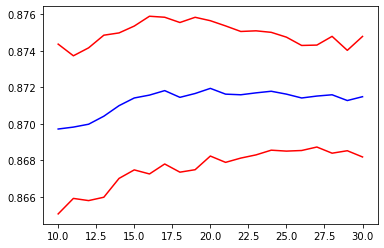

In [11]:
# Graficamos los resultados
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_inferior'], color='r')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['score_medio'], color='b')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_superior'], color='r');

In [12]:
# Identificamos el score máximo
df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max()]

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
10,0.871942,0.0037,20,0.875642,0.868241


In [13]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max(), 'n_neighbors'].values[0]
print("best k",best_k)

# Elegimos el modelo óptimo de acuerdo a las pruebas de cross validation
model = KNeighborsClassifier(n_neighbors=best_k)

# Lo ajustamos sobre los datos de entrenamiento
model.fit(X_train, y_train)

# Evaluamos qué accuracy obtenemos en train
print("accuracy_score en train",accuracy_score(y_train, model.predict(X_train)).round(2))

best k 20


KNeighborsClassifier(n_neighbors=20)

accuracy_score en train 0.88


In [14]:
# Lo utilizamos para predecir en test
X_test = scaler.transform(X_test) # ¡Importantísimo estandarizar también los datos de test con las medias y desvíos aprendidos en train!
y_pred = model.predict(X_test)

# Evaluamos el accuracy del modelo en test
print("accuracy_score en test",accuracy_score(y_test, y_pred).round(2))



accuracy_score en test 0.87


<a id="section_confusion"></a>
## Matriz de confusión

In [15]:
# Obtenemos la matriz de confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[26611,  1377],
       [ 3688,  6422]], dtype=int64)

#### Graficar la matriz de confusión

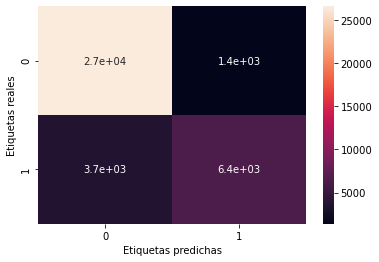

In [16]:
# Graficamos la matriz de confusión para visualizarla mejor
sns.heatmap(cm, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [17]:
# Podemos calcular manualmente la exactitud de nuestro modelo...
((cm[0,0] + cm[1,1]) / len(y_pred)).round(2)

0.87

In [18]:
# ... o computarla utilizando el método del accuracy score
accuracy_score(y_test, y_pred).round(2)

0.87

<a id="section_conclusion"></a>
## Conclusión

## 4.1. Regresión logística  (Mae)

In [3]:
print(data_covid.nunique())
print(data_covid.shape)

inpatient                   2
agegroup_10-19              2
agegroup_20-29              2
agegroup_30-39              2
agegroup_40-49              2
agegroup_50-59              2
agegroup_60-69              2
agegroup_70-79              2
agegroup_80-89              2
agegroup_90-99              2
asthma_Y                    2
cardiovascular_Y            2
chronic_kidney_failure_N    2
chronic_kidney_failure_Y    2
copd_Y                      2
covid_NOA                   2
covid_Y                     2
diabetes_N                  2
diabetes_Y                  2
hypertension_Y              2
immunosuppression_Y         2
obesity_Y                   2
other_diseases_N            2
other_diseases_Y            2
pneumonia_Y                 2
pregnant_Y                  2
sex_M                       2
smoker_Y                    2
dtype: int64
(95244, 28)


In [4]:
x=data_covid.drop(["inpatient"],axis=1)
y=data_covid["inpatient"]
y=pd.DataFrame(y)
y

,inpatient
0,0
1,0
2,1
3,1
4,1
...,...
95239,1
95240,1
95241,1
95242,0


In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y)
print ("X_train:" , x_train.shape[0])
print ("y_train:" , y_train.shape[0])
print ("X_test:" , x_test.shape[0])
print ("y_test:" , y_test.shape[0])

X_train: 71433
y_train: 71433
X_test: 23811
y_test: 23811


In [6]:
y_train=pd.DataFrame(y_train)
y_train

,inpatient
42390,0
95108,1
81624,1
9004,0
39461,0
...,...
52950,0
22387,0
17719,0
47345,1


In [7]:
#Logistic regression
#scaler = StandardScaler()
#x_trainstd = scaler.fit_transform(x_train)
#x_teststd = scaler.transform(x_test)
lr = LogisticRegression(class_weight="balance")
lr.fit(x_train, y_train)
score_lr= lr.score(x_test, y_test)

LogisticRegression(class_weight='balance')

In [8]:
print ("Logistic Regression Score:", score_lr)

Logistic Regression Score: 0.8724119104615514


In [9]:
y_pred_lr = lr.predict(x_test)

In [10]:
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))

AS LR:
 0.8724119104615514


In [11]:
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))

CM LR:
 [[16743   749]
 [ 2289  4030]]


In [12]:
lr.intercept_

array([0.30814338])

In [13]:
lr.coef_

array([[-1.27244218, -1.86639305, -1.84977101, -1.48115822, -1.07005924,
        -0.67849238, -0.17460585,  0.15369001,  0.45292554, -0.11854239,
         0.20174626, -0.11497042,  1.20836681,  0.60545338,  0.42768318,
         0.64710051, -0.86610004, -0.26151144,  0.16273945,  0.9353421 ,
         0.14415749, -0.61881295, -0.05807549,  3.48298041,  1.84744733,
         0.33852335,  0.03586595]])

In [14]:
print("LR:\n", classification_report(y_test,y_pred_lr))

LR:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     17492
           1       0.84      0.64      0.73      6319

    accuracy                           0.87     23811
   macro avg       0.86      0.80      0.82     23811
weighted avg       0.87      0.87      0.87     23811



In [15]:
importance = lr.coef_.flatten()

<BarContainer object of 27 artists>

Text(0.5, 1.0, 'Barplot Summary of Feature Importance')

Text(0.5, 0, 'score')

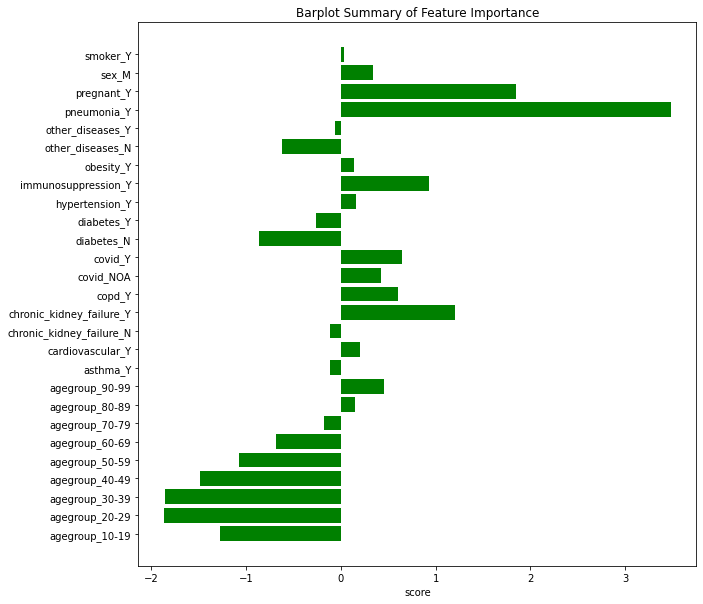

In [17]:
plt.rcParams["figure.figsize"] =(10,10)
plt.barh(x.columns,importance,color="g")
plt.title("Barplot Summary of Feature Importance")
plt.xlabel("score")
plt.show()

In [20]:
#LR
probs_lr=lr.predict_proba(x_test)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

Text(0.5, 1.0, 'ROC')

(0.0, 1.0)

(0.0, 1.0)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

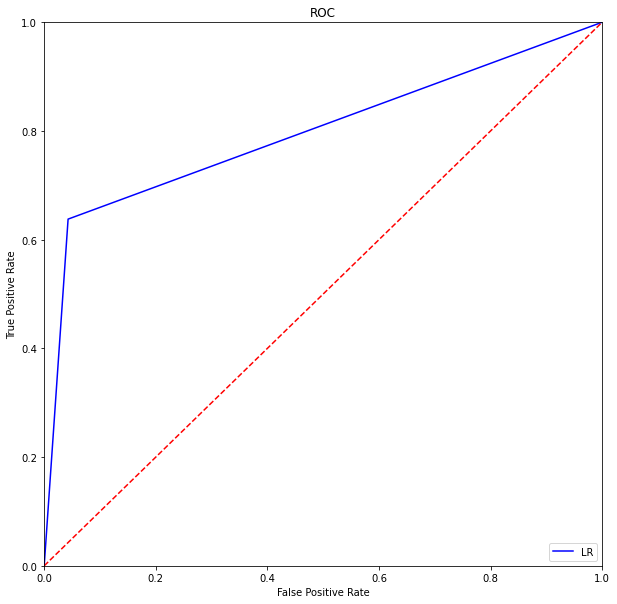

In [21]:
plt.title("ROC")

plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_lr)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4.2.1. Búsqueda y selección del hiperparámetro

### 4.1. Naive Bayes multinomial (Enzo)


In [19]:
## 4.1.1. Categorización de edad (o no :/)